### DB 연결

In [1]:
import psycopg2

conn = psycopg2.connect(
  'host=localhost port=5432 dbname=postgres user=postgres password=postgres',
  options='-c search_path=sbd'
)
conn.set_session(autocommit=True)
cur = conn.cursor()

### 기초통계량

In [2]:
import pandas as pd

cur.execute(
  f'''
  select
    zone_id,
    level,
    level_description,
    public.st_area(geometry) area,
    public.st_perimeter(geometry) perimeter
  from expected_flooding_zone
  '''
)
ef_zone = pd.DataFrame(
  cur.fetchall(),
  columns=[
    col[0]
    for col
    in cur.description
  ]
)

In [3]:
ef_zone.describe(include='all')

,zone_id,level,level_description,area,perimeter
count,2094.000000,2094,2094,2094.000000,2094.000000
unique,NaN,8,8,NaN,NaN
top,NaN,3,0.5mm 이상 1.0mm 미만,NaN,NaN
freq,NaN,784,784,NaN,NaN
mean,1048.205349,NaN,NaN,7859.914877,310.837076
std,604.990178,NaN,NaN,42665.277775,1123.961887
min,1.000000,NaN,NaN,0.005296,0.356440
25%,524.250000,NaN,NaN,40.498978,27.743482
50%,1048.500000,NaN,NaN,443.236222,92.122797
75%,1571.750000,NaN,NaN,2004.674171,227.674866


- area(구역 면적)
  - 최소값은 0.01㎡보다 작고 최대값은 81만㎡가 넘어 차이가 매우 크다.
  - 평균은 7,860㎡인데, 중위값은 443㎡으로 차이가 매우 크다. 극대값으로 인해 평균이 크게 상승한 것 같다.
- perimeter(구역 둘레)
  - 최소값은 0.3m이고 최대값은 27km여서 차이가 매우 크다.
  - 평균은 310m인데, 중위값은 92m로 평균이 중위값보다 확연히 크다. 극대값으로 인해 평균이 상승한 것 같다.

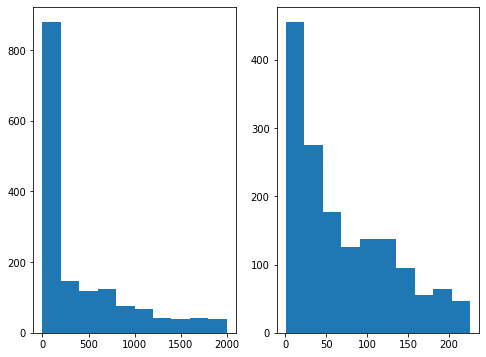

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].hist(ef_zone[ef_zone.area <= 2004].area)
axs[1].hist(ef_zone[ef_zone.perimeter <= 227].perimeter)
plt.show()

- area와 perimeter의 3분위수(3-quantile) 미만의 히스토그램을 보면, 두 변수 모두 0에 쏠려있다(left-skewed).
- 상대적으로 area의 치우침이 더 심하다.

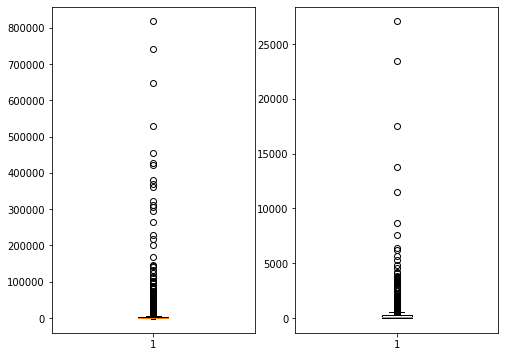

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].boxplot(ef_zone.area)
axs[1].boxplot(ef_zone.perimeter)
plt.show()

- maximum 보다 큰 outlier의 값이 너무 커서 boxplot의 형태를 알아보기 어렵다.

In [6]:
import numpy as np

area_1q = np.quantile(ef_zone.area, 0.25)
area_3q = np.quantile(ef_zone.area, 0.75)
area_iqr = area_3q - area_1q
print('area IQR :', round(area_iqr,2))
perimeter_1q = np.quantile(ef_zone.perimeter, 0.25)
perimeter_3q = np.quantile(ef_zone.perimeter, 0.75)
perimeter_iqr = perimeter_3q - perimeter_1q
print('perimeter IQR :', round(perimeter_iqr,2))

area IQR : 1964.18
perimeter IQR : 199.93


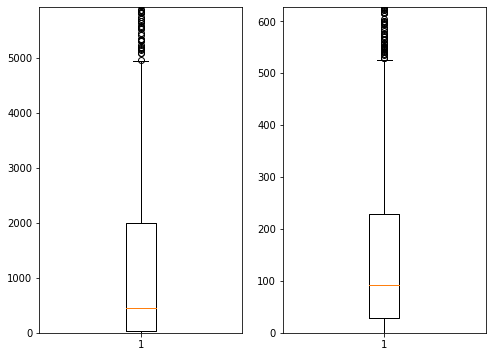

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].boxplot(ef_zone.area)
axs[0].set_ylim(
  [
    area_1q-1.5*area_iqr if area_1q-1.5*area_iqr > 0 else 0, # 최소 0
    area_3q+1.5*area_iqr+0.5*area_iqr # outlier 일부 출력
  ]
)
axs[1].boxplot(ef_zone.perimeter)
axs[1].set_ylim(
  [
    perimeter_1q-1.5*perimeter_iqr if perimeter_1q-1.5*perimeter_iqr > 0 else 0, # 최소 0
    perimeter_3q+1.5*perimeter_iqr+0.5*perimeter_iqr # outlier 일부 출력
  ]
)
plt.show()

- area와 perimeter의 lower_bound가 0보다 작아서, 작은 outlier는 존재하지 않음

### level 단위 통계
####  level 별 개수

In [8]:
cur.execute(
  f'''
  select
    level,
    count(*) count,
    sum(public.st_area(geometry)) area
  from expected_flooding_zone
  group by level
  order by level
  '''
)
ef_zone_level = pd.DataFrame(
  cur.fetchall(),
  columns=[
    col[0]
    for col
    in cur.description
  ]
)

In [9]:
ef_zone_level

,level,count,area
0,1,203,3.071175e+06
1,2,683,9.546084e+06
2,3,784,2.595345e+06
3,4,213,8.819425e+05
4,5,103,2.568882e+05
5,6,60,7.078451e+04
6,7,35,2.839409e+04
7,8,13,8.048301e+03


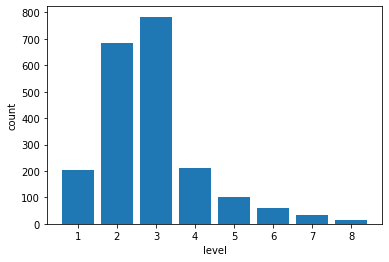

In [10]:
plt.bar(
  ef_zone_level['level'],
  ef_zone_level['count']
)
plt.xlabel('level')
plt.ylabel('count')
plt.show()

- level 개수 합계는 3과 2가 압도적으로 많다.

### level 별 면적 합계

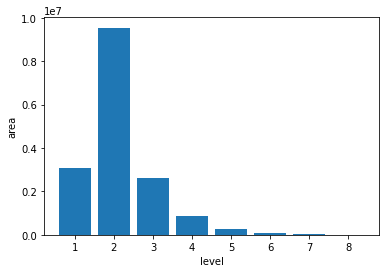

In [11]:
plt.bar(
  ef_zone_level['level'],
  ef_zone_level['area']
)
plt.xlabel('level')
plt.ylabel('area')
plt.show()

- level 면적 합계는 2가 압도적으로 많다.

### level 별 면적 평균

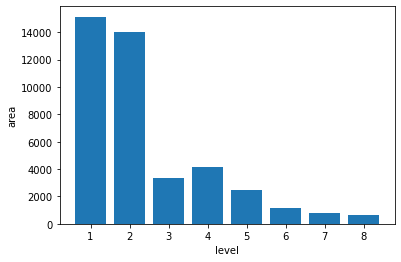

In [12]:
plt.bar(
  ef_zone_level['level'],
  ef_zone_level['area'] / ef_zone_level['count']
)
plt.xlabel('level')
plt.ylabel('area')
plt.show()

- level 면적 평균값은 1 > 2 > ... 순으로 가장 크다.
- level 3보다 4가 평균 면적이 높은 것이 특징이다.

### 공간 분포 확인(in QGIS)
QGIS에서 진행되며 [블로그](https://velog.io/@wkfyde/2022-공간빅데이터-경진대회-4-1.-침수예상도-분석)에 정리